<a href="https://colab.research.google.com/github/Le-Zheng/analytics-zoo/blob/ncfdataframe/docs/docs/colab-notebook/orca/quickstart/ncf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


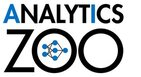
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest release version or latest pre-release version using `pip install --pre  analytics-zoo`. 

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre analytics-zoo

In [ ]:
# Install python dependencies
!pip install tensorflow==1.15.0

## **NCF (data preprocessing with Spark Dataframes)** 

In this guide we will describe how to use Spark Dataframes to process large-scale dataset.

#### **Intialization** 

import necessary libraries

In [ ]:
import os
import zipfile
import argparse

import numpy as np
import tensorflow as tf

from bigdl.dataset import base
from sklearn.model_selection import train_test_split

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext
from zoo.orca.learn.tf.estimator import Estimator
from zoo.orca.data import SharedValue
import zoo.orca.data.pandas

## **Init Orca Context** 

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=4) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

## **Data Preprocessing with Spark Dataframes**

Orca supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization.

In [4]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [5]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

In [6]:
# read csv
from zoo.common.nncontext import *
sc = init_nncontext()
sqlcontext = SQLContext(sc)
df = sqlcontext.read.csv(new_rating_files, sep=':', header=True, inferSchema=True).toDF(
  "user", "item", "label", "timestamp")

user_set = df.select('user').collect()
item_set = df.select('item').collect()

min_user_id = min(user_set)[0]
max_user_id = max(user_set)[0]
min_item_id = min(item_set)[0]
max_item_id = max(item_set)[0]
print(min_user_id, max_user_id, min_item_id, max_item_id)

1 6040 1 3952


In [ ]:
# update label starting from 0
df = df.withColumn('label', df.label-1)

In [12]:
# split to train/test dataset
train_data, test_data = df.randomSplit([0.8, 0.2])

### **Define NCF Model**

In [ ]:
class NCF(object):
    def __init__(self, embed_size, user_size, item_size):
        self.user = tf.placeholder(dtype=tf.int32, shape=(None,))
        self.item = tf.placeholder(dtype=tf.int32, shape=(None,))
        self.label = tf.placeholder(dtype=tf.int32, shape=(None,))

        with tf.name_scope("GMF"):
            user_embed_GMF = tf.contrib.layers.embed_sequence(self.user,
                                                              vocab_size=user_size + 1,
                                                              embed_dim=embed_size,
                                                              unique=False
                                                              )
            item_embed_GMF = tf.contrib.layers.embed_sequence(self.item,
                                                              vocab_size=item_size + 1,
                                                              embed_dim=embed_size,
                                                              unique=False
                                                              )
            GMF = tf.multiply(user_embed_GMF, item_embed_GMF, name='GMF')

        # MLP part starts
        with tf.name_scope("MLP"):
            user_embed_MLP = tf.contrib.layers.embed_sequence(self.user,
                                                              vocab_size=user_size + 1,
                                                              embed_dim=embed_size,
                                                              unique=False,
                                                              )

            item_embed_MLP = tf.contrib.layers.embed_sequence(self.item,
                                                              vocab_size=item_size + 1,
                                                              embed_dim=embed_size,
                                                              unique=False
                                                              )
            interaction = tf.concat([user_embed_MLP, item_embed_MLP],
                                    axis=-1, name='interaction')

            layer1_MLP = tf.layers.dense(inputs=interaction,
                                         units=embed_size * 2,
                                         name='layer1_MLP')
            layer1_MLP = tf.layers.dropout(layer1_MLP, rate=0.2)

            layer2_MLP = tf.layers.dense(inputs=layer1_MLP,
                                         units=embed_size,
                                         name='layer2_MLP')
            layer2_MLP = tf.layers.dropout(layer2_MLP, rate=0.2)

            layer3_MLP = tf.layers.dense(inputs=layer2_MLP,
                                         units=embed_size // 2,
                                         name='layer3_MLP')
            layer3_MLP = tf.layers.dropout(layer3_MLP, rate=0.2)

        # Concate the two parts together
        with tf.name_scope("concatenation"):
            concatenation = tf.concat([GMF, layer3_MLP], axis=-1,
                                      name='concatenation')
            self.logits = tf.layers.dense(inputs=concatenation,
                                          units=5,
                                          name='predict')

            self.logits_softmax = tf.nn.softmax(self.logits)

            self.class_number = tf.argmax(self.logits_softmax, 1)

        with tf.name_scope("loss"):
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=self.label, logits=self.logits, name='loss'))

        with tf.name_scope("optimzation"):
            self.optim = tf.train.AdamOptimizer(1e-3, name='Adam')
            self.optimizer = self.optim.minimize(self.loss)

embedding_size=16
model = NCF(embedding_size, max_user_id, max_item_id)

### **Fit with Orca Estimator**

In [ ]:
batch_size=1280
epochs=1
model_dir='./'

# create an Estimator.
estimator = Estimator.from_graph(
            inputs=[model.user, model.item],
            outputs=[model.class_number],
            labels=[model.label],
            loss=model.loss,
            optimizer=model.optim,
            model_dir=model_dir,
            metrics={"loss": model.loss})

estimator.fit(data=train_data,
        batch_size=1280,
        epochs=1,
        feature_cols=['user', 'item'],
        label_cols=['label'],
        validation_data=test_data)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
estimator.save_tf_checkpoint(checkpoint_path)
estimator.sess.close()

In [14]:
# predict using the Estimator

def predict(predict_data, user_size, item_size):

    predict_data = test.drop("label")
    tf.reset_default_graph()

    with tf.Session() as sess:
        model = NCF(embedding_size, user_size, item_size)

        saver = tf.train.Saver(tf.global_variables())
        checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
        saver.restore(sess, checkpoint_path)

        estimator = Estimator.from_graph(
            inputs=[model.user, model.item],
            outputs=[model.class_number],
            sess=sess,
            model_dir=model_dir
        )
        predict_result = estimator.predict(predict_data, batch_size=1280, feature_cols=['user', 'item'])
        predict_result.select('prediction').show(10)

predict(test_data, max_user_id, max_item_id)

INFO:tensorflow:Restoring parameters from ./NCF.ckpt
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmp7arwreq5/saved_model.pb
2021-02-01 07:30:31 WARN  TFNetForInference$:234 - Loading TensorFlow SavedModel: SavedModel tag is not defined, using <serve>


2021-02-01 07:30:31.524850: I tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /tmp/tmp7arwreq5
2021-02-01 07:30:31.528883: I tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2021-02-01 07:30:31.535007: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-02-01 07:30:31.549293: I tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2021-02-01 07:30:31.645341: I tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 120491 microseconds.
[Stage 2585:>                                                       (0 + 1) / 1]Prepending /usr/local/lib/python3.6/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Prepending /usr/local/lib/python3.6/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path
Prepending /usr/local/lib/python3.6/dist-package

+----------+
|prediction|
+----------+
|       3.0|
|       3.0|
|       4.0|
|       3.0|
|       3.0|
|       3.0|
|       3.0|
|       3.0|
|       3.0|
|       3.0|
+----------+
only showing top 10 rows



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 170, in manager
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 73, in worker
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 402, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.6/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 717, in read_int
    raise EOFError
EOFError


In [ ]:
stop_orca_context()